In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import scikit_posthocs as sp

## SETUP

In [2]:
# Setup; data loading and cleaning
data_file = "/home/davidb/DESTv2_data_paper/15.demographic_inference/output/moments_output_jackknife.tsv"
max_num_params = 8
est_cols = ['est' + str(i) for i in range(max_num_params)]

# Read in data
df = pd.read_csv(data_file, sep='\t', header=None,
                     names=['model', 'pop_of_interest'] + \
                           ['init' + str(i) for i in range(max_num_params)] + \
                           est_cols + \
                           ['upper_bound' + str(i) for i in range(max_num_params)] + \
                           ['log_likelihood', 'collapsed_pop_ll', 'func_calls', 'grad_calls',
                            'maxiter', 'hour_limit',
                            'jackknife_id', 'region'])

# Group by model, as applied to each jackknife replicate of each region
df.groupby(['region', 'model', 'pop_of_interest', 'jackknife_id'],
           dropna=False).mean()

# Get the best fit for each jackknife replicate
df = df.loc[df.groupby(['region', 'model', 'pop_of_interest', 'jackknife_id'],
                       dropna=False)\
            ['log_likelihood'].idxmax()]
df = df[['region', 'model', 'pop_of_interest', 'jackknife_id', 'log_likelihood', 'collapsed_pop_ll'] + \
        est_cols]

def calculate_ci(x):
    return (list(x.nsmallest(2))[0], 
            list(x.nlargest(2))[0])

df = df.replace({'pop_of_interest': {0.0: '0', 
                                     1.0 : '1',
                                     2.0 : '2',
                                     3.0 : '3',
                                     np.nan: 'NA'},
                 'ci_bound': {0: 'lower', 1: 'upper'}})

# Merge model and pop of interest, which do not need to be distinguished now that
# we're only considering models within each region, and not calling general model
# functions.
pop_of_interest_suffices = ['_' + poi if poi != 'NA' else '' for poi in df['pop_of_interest']]
df['model'] = df['model'] + pop_of_interest_suffices
df.drop(columns=['pop_of_interest'], inplace=True)

#####
# Everything below this line is clean-up of old models and model names
#####

# Filter out attempted, but unused split-with-asymmetric-migration model.
df = df[df['model'] != 'split_asymmig']
# Rename models for clarity
df[df['region'] == "Transatlantic"] = df.replace({'model': {'admixture_0': 'EUExWAfr',
                                                            'admixture_1': 'EUWxWAfr',
                                                            'admixture_2': 'EUExSAfr',
                                                            'admixture_3': 'EUWxSAfr'}})
df[df['region'] == "Australia"] = df.replace({'model': {'admixture_0': 'EUWxWAfr',
                                                        'admixture_1': 'EUExWAfr',
                                                        'admixture_2': 'EUWxSAfr',
                                                        'admixture_3': 'EUExSAfr'}})
df = df.replace({'model': {'two_epoch': 'one_pop'}})

## MODEL SELECTION

In [3]:
# Test whether the one-population model gives significantly greater collapsed log-likelihood
# than the split model of the mainland region with a non-parametric two-sample test.
p = scipy.stats.wilcoxon(df[(df.region == "mainland") & (df.model == "one_pop")].collapsed_pop_ll,
                            df[(df.region == "mainland") & (df.model == "split")].collapsed_pop_ll,
                            alternative='greater').pvalue
print(f"p={p}, so we reject the null hypothesis that the models are equally good\n"
       "and conclude that the one-population model is significantly better than\n"
       "the split model of the mainland region.")

p=7.025937520666048e-07, so we reject the null hypothesis that the models are equally good
and conclude that the one-population model is significantly better than
the split model of the mainland region.


In [4]:
# Test whether the one-population model gives significantly greater collapsed log-likelihood
# than the split model of the Americas region with a non-parametric two-sample test.
p = scipy.stats.wilcoxon(df[(df.region == "Americas") & (df.model == "one_pop")].collapsed_pop_ll,
                            df[(df.region == "Americas") & (df.model == "split")].collapsed_pop_ll,
                            alternative='greater').pvalue
print(f"p={p}, so we reject the null hypothesis that the models are equally good\n"
       "and conclude that the one-population model is significantly better than\n"
       "the split model of the Americas region.")

p=6.897607818245888e-09, so we reject the null hypothesis that the models are equally good
and conclude that the one-population model is significantly better than
the split model of the Americas region.


In [5]:
# Test whether model has a significant effect on collapsed log-likelihood of fit
# to the Europe region with a non-parametric multi-sample test.
Europe_models = np.array(["split"] + [f"admixture_{i}" for i in range(3)] + [f"twosplits_{i}" for i in range(3)])

p = scipy.stats.kruskal(*[df[(df.region == "Europe") & (df.model == model)].collapsed_pop_ll
                          for model in Europe_models]).pvalue
print(f"p={p}, so we reject the null hypothesis that the models are equally good\n"
       "and conclude that the one-population model is significantly better than\n"
       "the split model of the Europe region.")
print()

model_to_ll = {model: df[(df.region == "Europe") & (df.model == model)].collapsed_pop_ll.mean()
               for model in Europe_models}
print(pd.DataFrame({"model": list(model_to_ll.keys()), "mean_CLL": list(model_to_ll.values())}))
print()

print("The split model gives the greatest collapsed log-likelihood, so we will perform\n"
      "post-hoc testing of its superiority to the other six models.")
print()

optimal_Europe_model = "split"
ps = sp.posthoc_dunn([df[(df.region == "Europe") & (df.model == model)].collapsed_pop_ll for model in Europe_models],
                     p_adjust='fdr_by')

opt_model_idx = np.where(Europe_models == optimal_Europe_model)[0][0] + 1
ps_w_split = np.concatenate((ps[opt_model_idx][:opt_model_idx-1], ps[opt_model_idx][opt_model_idx:]))
ps_df = pd.DataFrame(ps_w_split, index=Europe_models[Europe_models != optimal_Europe_model],
                     columns=["model_vs_split_p"])
print(ps_df)
print()

print("All (Benjamini-Hochberg-corrected) p-values are less than 0.05, so we reject\n"
      "the null hypotheses that the split model is as good as any of the six 3-population\n"
      "models. The split model is significantly better than all of them.")

p=8.738345441526625e-28, so we reject the null hypothesis that the models are equally good
and conclude that the one-population model is significantly better than
the split model of the Europe region.



         model  mean_CLL
0        split -4.406279
1  admixture_0 -4.420659
2  admixture_1 -4.419902
3  admixture_2 -4.422253
4  twosplits_0 -4.420161
5  twosplits_1 -4.420271
6  twosplits_2 -4.419369

The split model gives the greatest collapsed log-likelihood, so we will perform
post-hoc testing of its superiority to the other six models.

             model_vs_split_p
admixture_0      4.186598e-15
admixture_1      5.224632e-10
admixture_2      2.199179e-27
twosplits_0      8.547421e-12
twosplits_1      2.228306e-12
twosplits_2      3.290343e-07

All (Benjamini-Hochberg-corrected) p-values are less than 0.05, so we reject
the null hypotheses that the split model is as good as any of the six 3-population
models. The split model is significantly better than all of them.


In [6]:
# Test whether model has a significant effect on collapsed log-likelihood of fit
# to the Transatlantic region with a non-parametric multi-sample test.
TA_models = df[df.region == "Transatlantic"].model.unique()

p = scipy.stats.kruskal(*[df[(df.region == "Transatlantic") & (df.model == model)].collapsed_pop_ll
                          for model in TA_models]).pvalue
print(f"p={p}, so we reject the null hypothesis that the models are equally good\n"
       "and conclude that the one-population model is significantly better than\n"
       "the split model of the Transatlantic region.")
print()

model_to_ll = {model: df[(df.region == "Transatlantic") & (df.model == model)].collapsed_pop_ll.mean()
               for model in TA_models}
print(pd.DataFrame({"model": list(model_to_ll.keys()), "mean_CLL": list(model_to_ll.values())}))
print()

print("The split model gives the greatest collapsed log-likelihood, so we will perform\n"
      "post-hoc testing of its superiority to the other six models.")
print()

optimal_model = "EUExSAfr"
ps = sp.posthoc_dunn([df[(df.region == "Transatlantic") & (df.model == model)].collapsed_pop_ll 
                      for model in TA_models],
                     p_adjust='fdr_by')
opt_model_idx = np.where(TA_models == optimal_model)[0][0] + 1
ps_w_split = np.concatenate((ps[opt_model_idx][:opt_model_idx-1], ps[opt_model_idx][opt_model_idx:]))
ps_df = pd.DataFrame(ps_w_split, index=TA_models[TA_models != optimal_model],
                     columns=["model_vs_split_p"])
print(ps_df)
print()

print("All (Benjamini-Hochberg-corrected) p-values are less than 0.05, so we reject\n"
      "the null hypotheses and conclude that the Americas are best described as\n"
      "resulting from the admixture of EU-E and southern Africa (as represented by Zambia\n"
      "and Zimbabwe).")

p=2.787106945482969e-31, so we reject the null hypothesis that the models are equally good
and conclude that the one-population model is significantly better than
the split model of the Transatlantic region.

      model  mean_CLL
0  EUExWAfr -6.390619
1  EUWxWAfr -6.255848
2  EUExSAfr -6.059615
3  EUWxSAfr -6.338154

The split model gives the greatest collapsed log-likelihood, so we will perform
post-hoc testing of its superiority to the other six models.

          model_vs_split_p
EUExWAfr      1.582489e-28
EUWxWAfr      3.320823e-04
EUWxSAfr      1.013652e-14

All (Benjamini-Hochberg-corrected) p-values are less than 0.05, so we reject
the null hypotheses and conclude that the Americas are best described as
resulting from the admixture of EU-E and southern Africa (as represented by Zambia
and Zimbabwe).


In [7]:
# Test whether model has a significant effect on collapsed log-likelihood of fit
# to the Transatlantic region with a non-parametric multi-sample test.
Aus_models = df[df.region == "Australia"].model.unique()

p = scipy.stats.kruskal(*[df[(df.region == "Australia") & (df.model == model)].collapsed_pop_ll
                          for model in Aus_models]).pvalue
print(f"p={p}, so we reject the null hypothesis that the models are equally good\n"
       "and conclude that the one-population model is significantly better than\n"
       "the split model of the Australia region.")
print()

model_to_ll = {model: df[(df.region == "Australia") & (df.model == model)].collapsed_pop_ll.mean()
               for model in Aus_models}
print(pd.DataFrame({"model": list(model_to_ll.keys()), "mean_CLL": list(model_to_ll.values())}))
print()

print("The split model gives the greatest collapsed log-likelihood, so we will perform\n"
      "post-hoc testing of its superiority to the other six models.")
print()

optimal_Europe_model = "EUWxSAfr"
ps = sp.posthoc_dunn([df[(df.region == "Australia") & (df.model == model)].collapsed_pop_ll 
                      for model in Aus_models],
                     p_adjust='fdr_by')
opt_model_idx = np.where(Aus_models == optimal_Europe_model)[0][0] + 1
ps_w_split = np.concatenate((ps[opt_model_idx][:opt_model_idx-1], ps[opt_model_idx][opt_model_idx:]))
ps_df = pd.DataFrame(ps_w_split, index=Aus_models[Aus_models != optimal_Europe_model],
                     columns=["model_vs_split_p"])
print(ps_df)
print()

print("All (Benjamini-Hochberg-corrected) p-values are less than 0.05, so we reject\n"
      "the null hypotheses and conclude that the Americas are best described as\n"
      "resulting from the admixture of EU-E and East Africa (as represented by Zambia\n"
      "and Zimbabwe).")

p=2.1742412046116315e-25, so we reject the null hypothesis that the models are equally good
and conclude that the one-population model is significantly better than
the split model of the Australia region.

      model  mean_CLL
0  EUWxWAfr -6.390005
1  EUExWAfr -6.423101
2  EUWxSAfr -6.188550
3  EUExSAfr -6.237031

The split model gives the greatest collapsed log-likelihood, so we will perform
post-hoc testing of its superiority to the other six models.

          model_vs_split_p
EUWxWAfr      4.326773e-09
EUExWAfr      2.839792e-23
EUExSAfr      2.509486e-02

All (Benjamini-Hochberg-corrected) p-values are less than 0.05, so we reject
the null hypotheses and conclude that the Americas are best described as
resulting from the admixture of EU-E and East Africa (as represented by Zambia
and Zimbabwe).


## MODEL PARAMETER ESTIMATES

In [8]:
print("95% CIs for parameter estimates for one-population model of mainland:")
opt_model = "one_pop"
print(f"L\t{np.array(df[(df.region == 'Americas') & (df.model == opt_model)]['collapsed_pop_ll'].quantile([0.025, 0.975]))}")
for i, param_name in enumerate(['nu', 'T']):
    ci = np.array(df[(df.region == "mainland") & (df.model == opt_model)]['est' + str(i)].quantile([0.025, 0.975]))
    print(f"{param_name}\t{ci}")

95% CIs for parameter estimates for one-population model of mainland:
L	[-2.61207082 -2.60715977]
nu	[1.85794596 2.10597247]
T	[0.02297162 0.02874046]


In [9]:
print("95% CIs for parameter estimates for one-population model of the Americas:")
opt_model = "one_pop"
print(f"L\t{np.array(df[(df.region == 'Americas') & (df.model == opt_model)]['collapsed_pop_ll'].quantile([0.025, 0.975]))}")
for i, param_name in enumerate(['nu', 'T']):
    ci = np.array(df[(df.region == "Americas") & (df.model == opt_model)]['est' + str(i)].quantile([0.025, 0.975]))
    print(f"{param_name}\t{ci}")

95% CIs for parameter estimates for one-population model of the Americas:
L	[-2.61207082 -2.60715977]
nu	[1.58762755 1.8860231 ]
T	[0.01854634 0.03073693]


In [10]:
print("95% CIs for parameter estimates for split model of Europe:")
opt_model = "split"
print(f"L\t{np.array(df[(df.region == 'Europe') & (df.model == opt_model)]['collapsed_pop_ll'].quantile([0.025, 0.975]))}")
for i, param_name in enumerate(['nu_EUW', 'nu_EUE', 'T_split', 'm']):
    ci = np.array(df[(df.region == "Europe") & (df.model == opt_model)]['est' + str(i)].quantile([0.025, 0.975]))
    print(f"{param_name}\t{ci}")

95% CIs for parameter estimates for split model of Europe:
L	[-4.40965402 -4.40345367]
nu_EUW	[2.82002992 2.94922152]
nu_EUE	[0.58929685 0.64438409]
T_split	[0.03808484 0.04016409]
m	[16.6489238  18.02249604]


In [11]:
# p_admix is the proportion of genetic material from the African population in the
# admixture event.
print("95% CIs for parameter estimates for admixture model of the Americas as EUExSAfr:")
opt_model = "EUExSAfr"
print(f"L\t{np.array(df[(df.region == 'Transatlantic') & (df.model == opt_model)]['collapsed_pop_ll'].quantile([0.025, 0.975]))}")
for i, param_name in enumerate(['nu_Afr', 'nu_EUE', 'nu_Am', 'T_split', 'T_admix', 'm2', 'm3', 'p_admix']):
    ci = np.array(df[(df.region == "Transatlantic") & (df.model == opt_model)]['est' + str(i)].quantile([0.025, 0.975]))
    print(f"{param_name}\t{ci}")

95% CIs for parameter estimates for admixture model of the Americas as EUExSAfr:
L	[-6.07480969 -6.04260235]
nu_Afr	[0.36379114 0.39992383]
nu_EUE	[0.69469272 0.74367556]
nu_Am	[0.79505027 0.96947208]
T_split	[0.15644274 0.83881196]
T_admix	[0.01856334 0.02118287]
m2	[1.00367891e-03 2.15084793e+00]
m3	[12.32206064 16.13708399]
p_admix	[0.79433422 0.82854144]


In [12]:
# p_admix is the proportion of genetic material from the African population in the
# admixture event.
print("95% CIs for parameter estimates for admixture model of the Americas as EUExSAfr:")
opt_model = "EUWxSAfr"
print(f"L\t{np.array(df[(df.region == 'Australia') & (df.model == opt_model)]['collapsed_pop_ll'].quantile([0.025, 0.975]))}")
for i, param_name in enumerate(['nu_Afr', 'nu_EUE', 'nu_Am', 'T_split', 'T_admix', 'm2', 'm3', 'p_admix']):
    ci = np.array(df[(df.region == "Australia") & (df.model == opt_model)]['est' + str(i)].quantile([0.025, 0.975]))
    print(f"{param_name}\t{ci}")

95% CIs for parameter estimates for admixture model of the Americas as EUExSAfr:
L	[-6.3668716  -6.00488869]
nu_Afr	[0.08374287 0.47872208]
nu_EUE	[0.39704415 1.02324465]
nu_Am	[0.62507922 1.38017237]
T_split	[0.05417212 0.63786478]
T_admix	[0.01523765 0.02570954]
m2	[0.07806849 2.00959753]
m3	[1.00541083e-03 4.26885525e+00]
p_admix	[0.0010196 0.0652216]


## PLOTTING FIG. S17

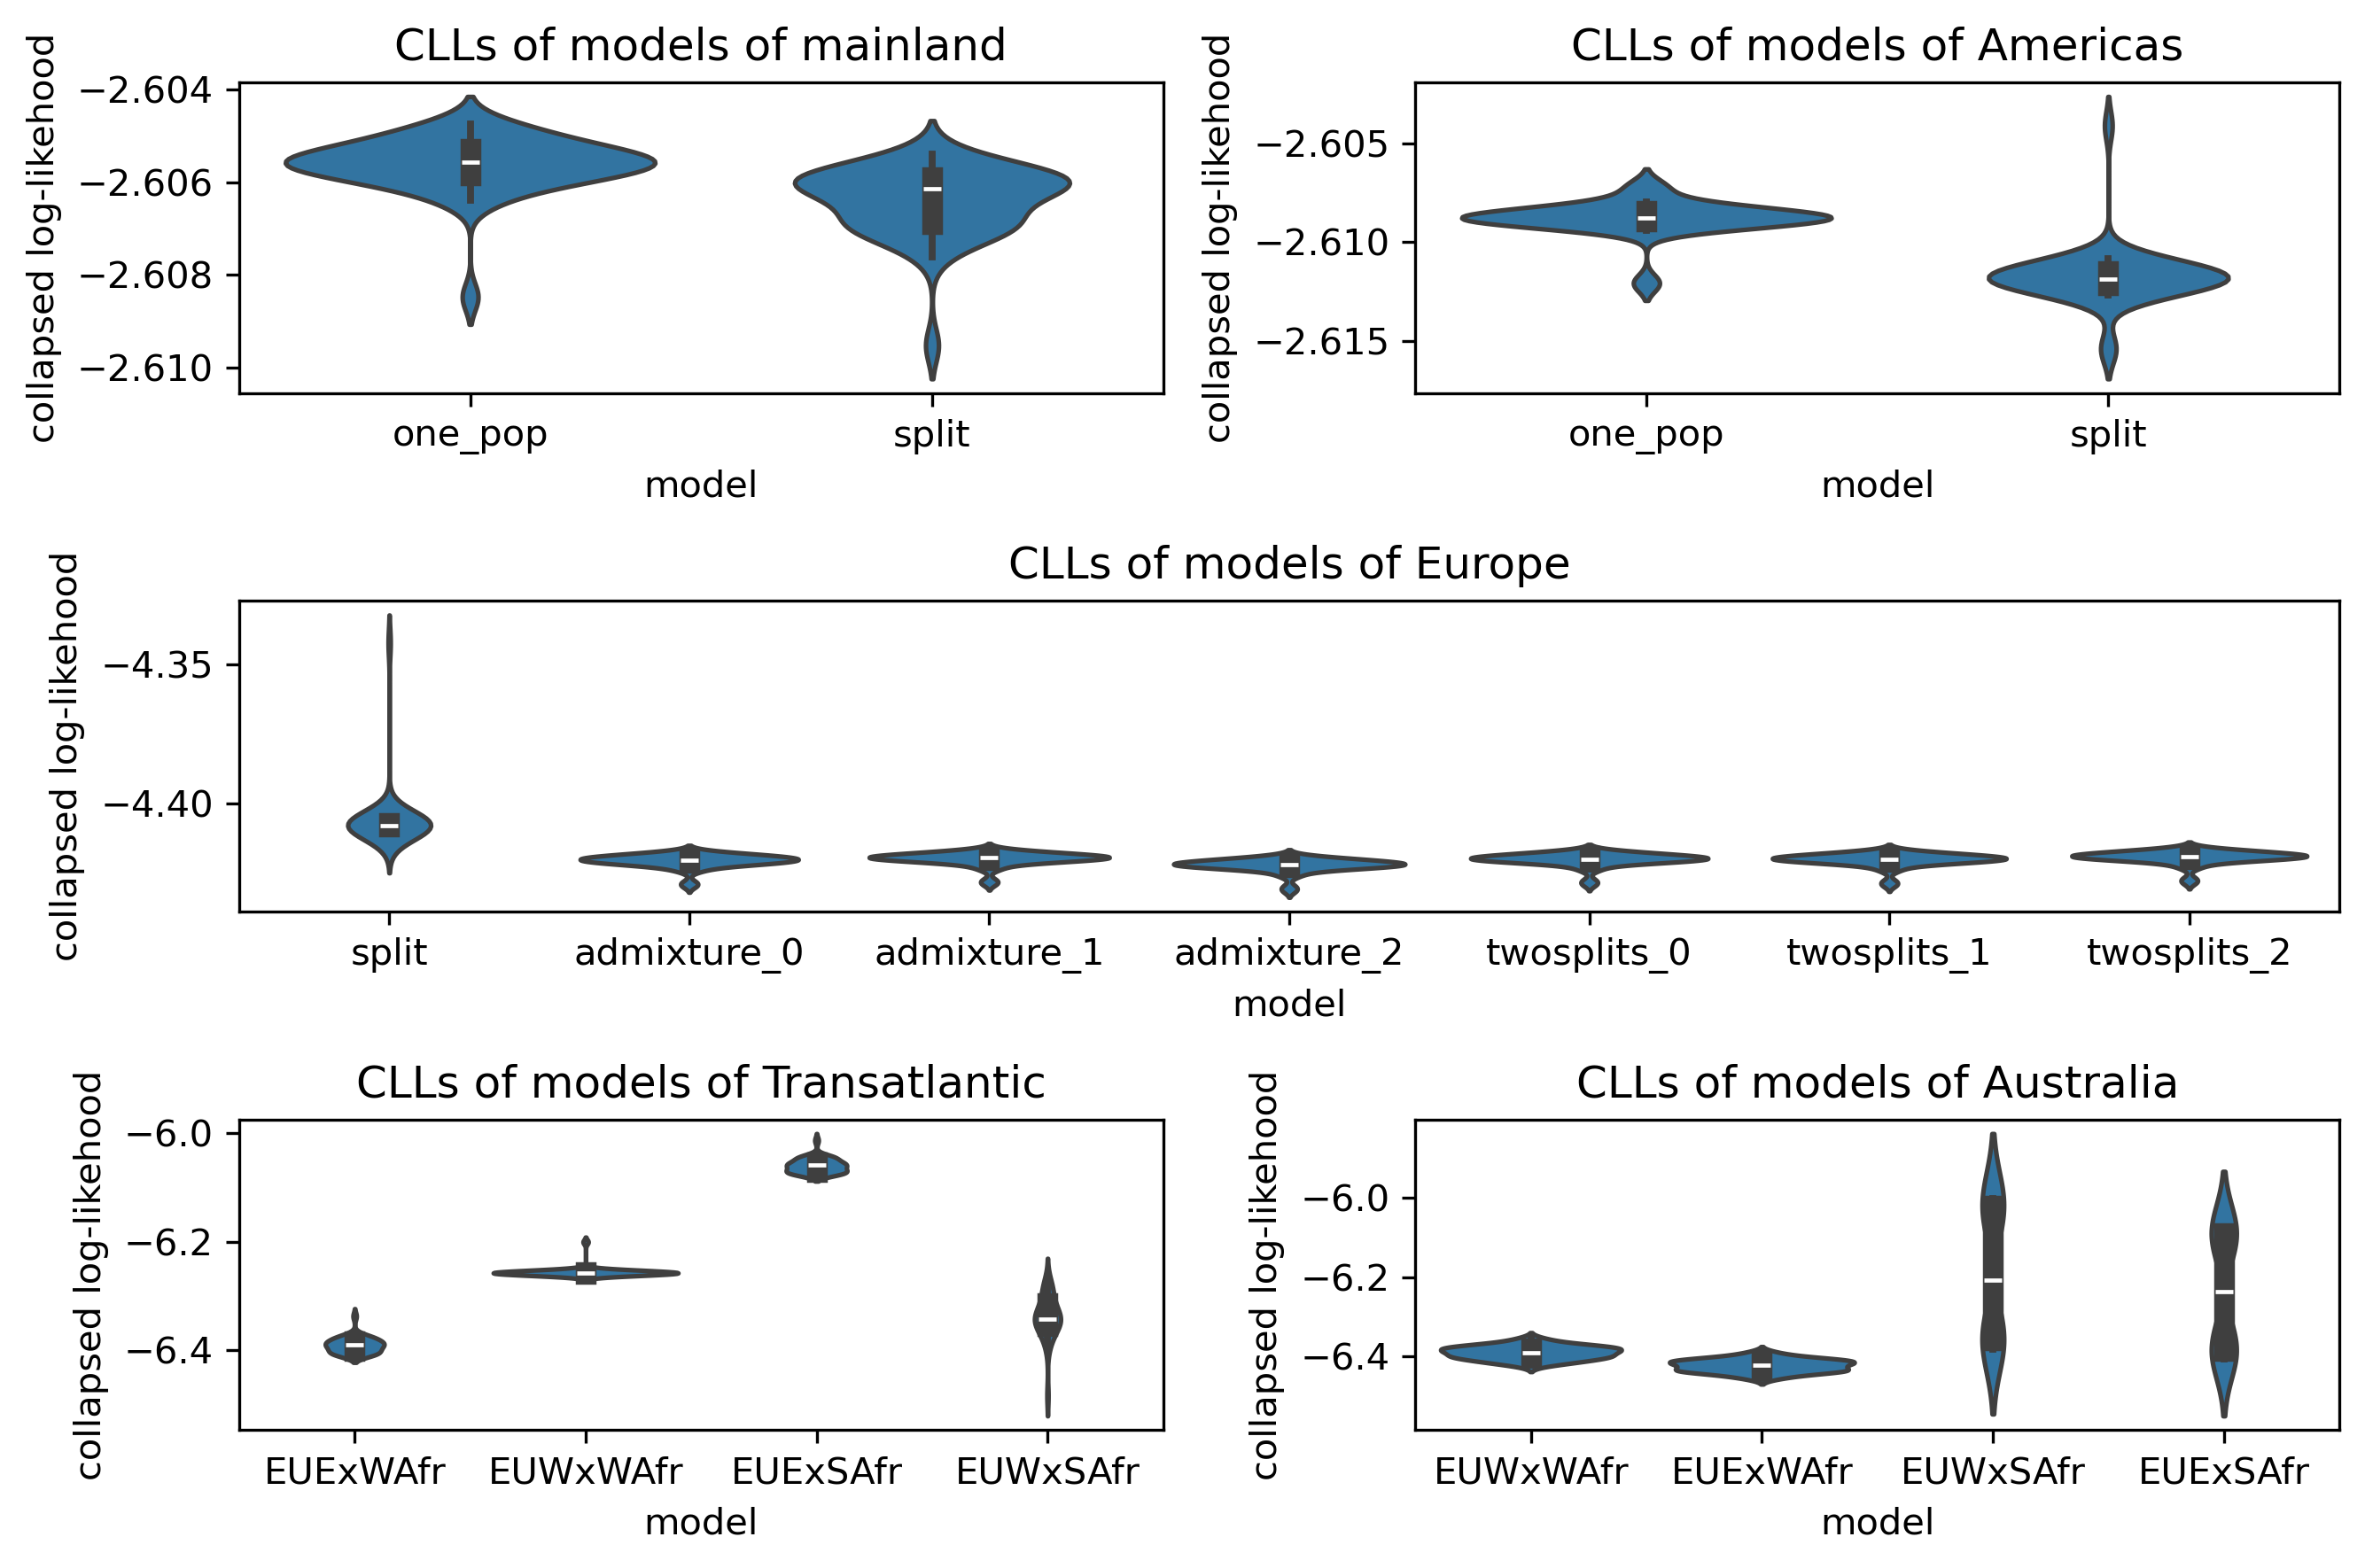

In [19]:
fig = plt.figure(figsize=(9, 6), dpi=300)
gs = fig.add_gridspec(3, 2)
ax_main = fig.add_subplot(gs[0, 0])
ax_amer = fig.add_subplot(gs[0, 1])
ax_euro = fig.add_subplot(gs[1, :])
ax_tran = fig.add_subplot(gs[2, 0])
ax_aust = fig.add_subplot(gs[2, 1])

def plot_violin(region, params, ax):
    sns.violinplot(data=df.loc[df['region'] == region], x="model", y='collapsed_pop_ll', 
                   order=params, ax=ax)
    ax.set_ylabel("collapsed log-likehood")
    ax.set_title(f"CLLs of models of {region}")
plot_violin("mainland", ["one_pop", "split"], ax_main)
plot_violin("Americas", ["one_pop", "split"], ax_amer)
plot_violin("Europe", Europe_models, ax_euro)
plot_violin("Transatlantic", TA_models, ax_tran)
plot_violin("Australia", Aus_models, ax_aust)

plt.tight_layout()
plt.show()

## PLOTTING FIG. S18